In [1]:
set.seed(30034)

In [2]:
# install.packages("corrplot")
# install.packages("plot.matrix")
# install.packages("ggplot2")
# install.packages("reshape2")
# install.packages("ramify")
# install.packages("SAVER")
# install.packages("MASS")

In [3]:
library(corrplot)
library(plot.matrix)
library(ggplot2)
library(reshape2)
library(ramify)
library(SAVER)
library(MASS)

corrplot 0.90 loaded


Attaching package: ‘ramify’


The following object is masked from ‘package:graphics’:

    clip




# Define constants

In [4]:
N <- 240
V <- 441
x1 <- 21
x2 <- 21
p <- 0
nsrcs <- 6

# Question 1: Synthetic dataset generation, data preporcessing, & data visualization

## 1 TC line plot

In [5]:
AV <- c(0,20,0,0,0,0)
IV <- c(30,45,60,40,40,40)
ones <- c(15,20,25,15,20,25)

In [6]:
tempTC = matrix(, nrow = N, ncol = nsrcs)
# Add elements to the empty matrix
for (i in rep(1:nsrcs)) {
    tempTC[, i] <- append(rep(0, AV[i]), rep(rep(1:0, times=c(ones[i], IV[i] - ones[i])), length.out=N - AV[i]))
}

In [7]:
TC <- scale(tempTC) 

In [8]:
pdf(file = "./images/TC_subplots.pdf", width = 8, height = 8)
par(mfrow = c(3, 3))
for (i in rep(1:nsrcs)) {
    plot(TC[,i], type="S", main=paste("Variable", i), xlab="", ylab="")
}
dev.off()

pdf 
  2

## 2 TC correlation plot

In [9]:
cc <- cor(TC)

In [10]:
pdf(file = "./images/TC_variable_correlations.pdf", width = 4, height = 4)
corrplot(cc, type="upper", method="color", title = "Variable Correlations", mar=c(0,0,1,0))
dev.off()

pdf 
  2

## 3 tmpSM plot

In [11]:
ones_v = list(rep(2:6),rep(2:6), rep(8:13), rep(8:13), rep(15:19), rep(15:19))
ones_h = list(rep(2:6), rep(15:19), rep(2:6), rep(15:19), rep(2:6), rep(15:19))

In [12]:
tempSM <- array(rep(NA, nsrcs*x1*x2), dim = c(x1, x2, nsrcs))
for (i in rep(1:nsrcs)) {
    tempM <- matrix(0, nrow = x1, ncol = x2)
    vertical <- unlist(ones_v[i])
    horizontal <- unlist(ones_h[i])
    tempM[vertical, horizontal] <- matrix(1, nrow = length(vertical), ncol = length(horizontal))
    tempSM[,,i] <- tempM
}

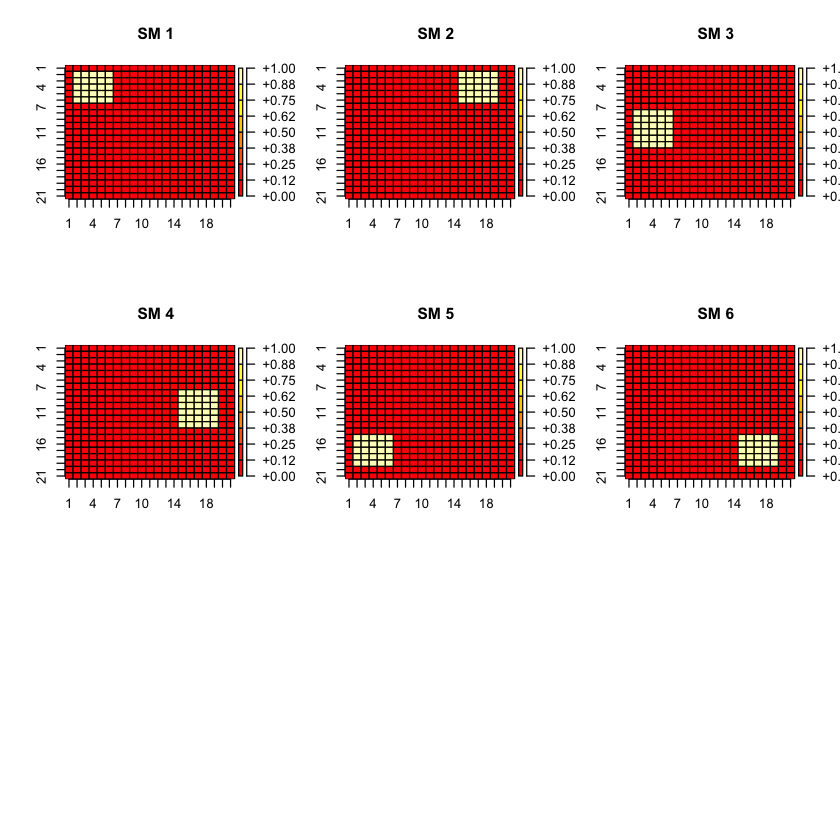

In [13]:

par(mfrow = c(3, 3))
for (i in rep(1:nsrcs)) {
    plot(tempSM[,,i], main=paste("SM", i),  xlab="", ylab="", col = heat.colors(8))
}

In [14]:
SM <- array(rep(NA, nsrcs*x1*x2), dim = c(nsrcs, x1*x2))
for (i in rep(1:nsrcs)) {
    SM[i,] <- as.vector(tempSM[,,i])
}

In [15]:
SM_cor <- cor(t(SM))

In [16]:
pdf(file = "./images/SM_variable_correlations.pdf", width = 4, height = 4)
corrplot(SM_cor, type="upper", method="color", title = "SM Correlations", mar=c(0,0,1,0))
dev.off()

pdf 
  2

## 4 Gaussian noise

In [17]:
t_var <- 0.25
s_var <- 0.015

In [18]:
gamma_t <- matrix(rnorm(N*nsrcs, mean = 0, sd = sqrt(t_var)), nrow = N, ncol = nsrcs)
gamma_s <- matrix(rnorm(nsrcs*V, mean = 0, sd = sqrt(s_var)), nrow = nsrcs, ncol = V)

In [19]:
gamma_t_cor <- cor(gamma_t)
gamma_s_cor <- cor(t(gamma_s))

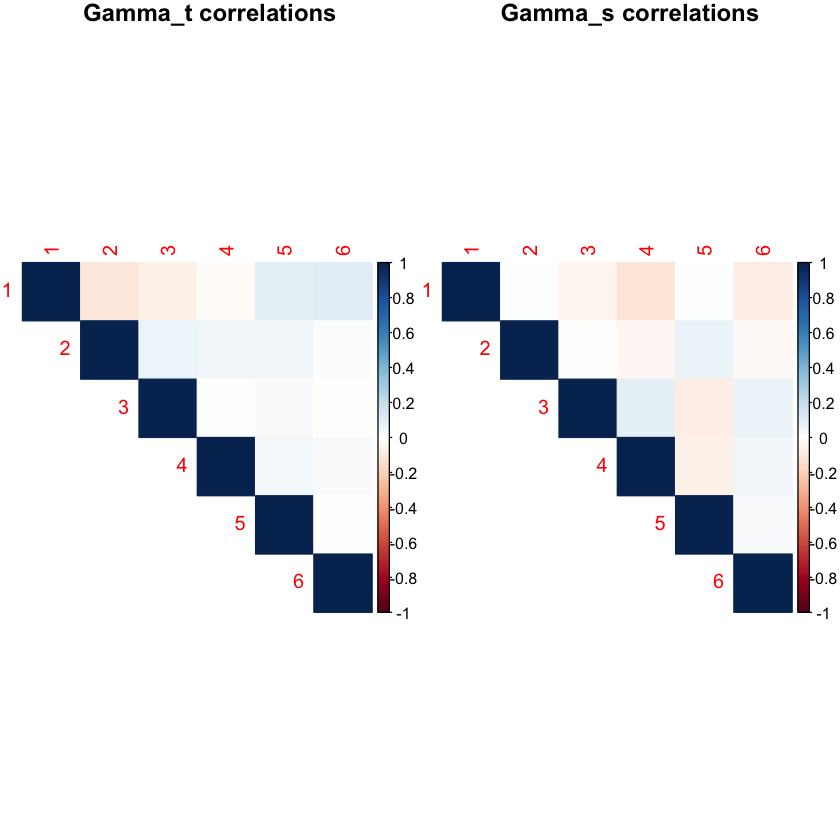

In [20]:
par(mfrow = c(1, 2))
corrplot(gamma_t_cor, type="upper", method="color", title = "Gamma_t correlations", mar=c(0,0,1,0))
corrplot(gamma_s_cor, type="upper", method="color", title = "Gamma_s correlations", mar=c(0,0,1,0))

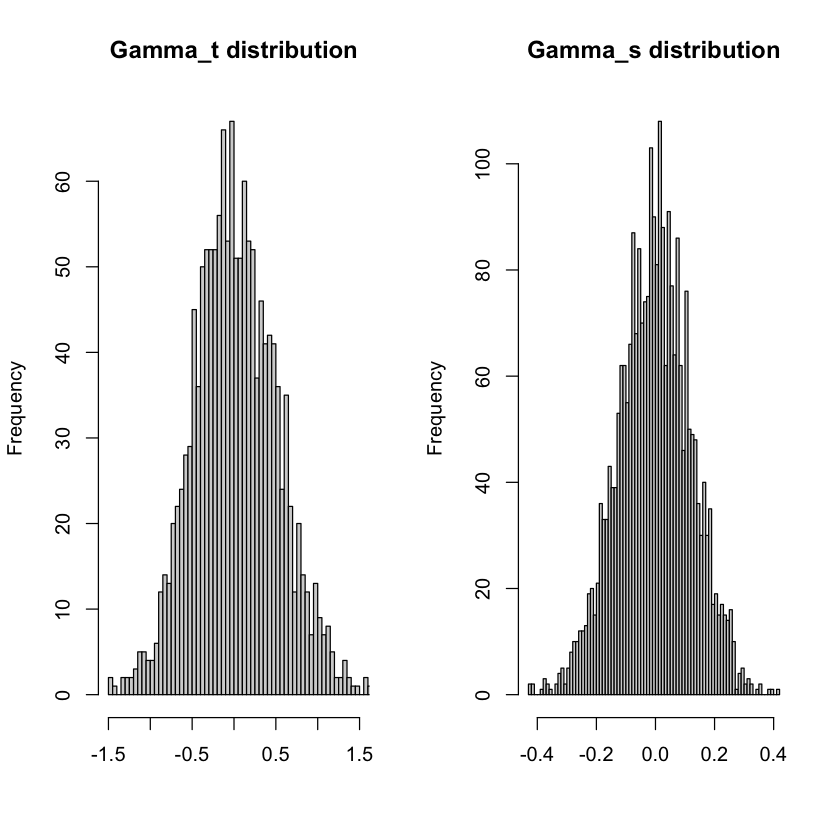

In [21]:
par(mfrow = c(1, 2))
hist(as.vector(gamma_t), xlim=c(-1.5, 1.5), breaks=100, main = "Gamma_t distribution", xlab = "")
hist(as.vector(gamma_s), breaks=100, main = "Gamma_s distribution", xlab="")

## 5 Sythetic dataset

In [22]:
tempX <- (TC+gamma_t)%*%(SM+gamma_s)

In [23]:
partial_X <- melt(tempX[, sample(c(1:240), size=100)])

In [24]:
pdf("./images/X_partial.pdf" , width = 7, height = 4)
p <- ggplot(data=partial_X, aes(x=Var1, y=value, color=as.factor(Var2))) + geom_line() + theme(legend.position = "none") +  labs(title = "Randomly selected time-series from X", x= "time",  y= "values")
print(p)
dev.off()

pdf 
  2

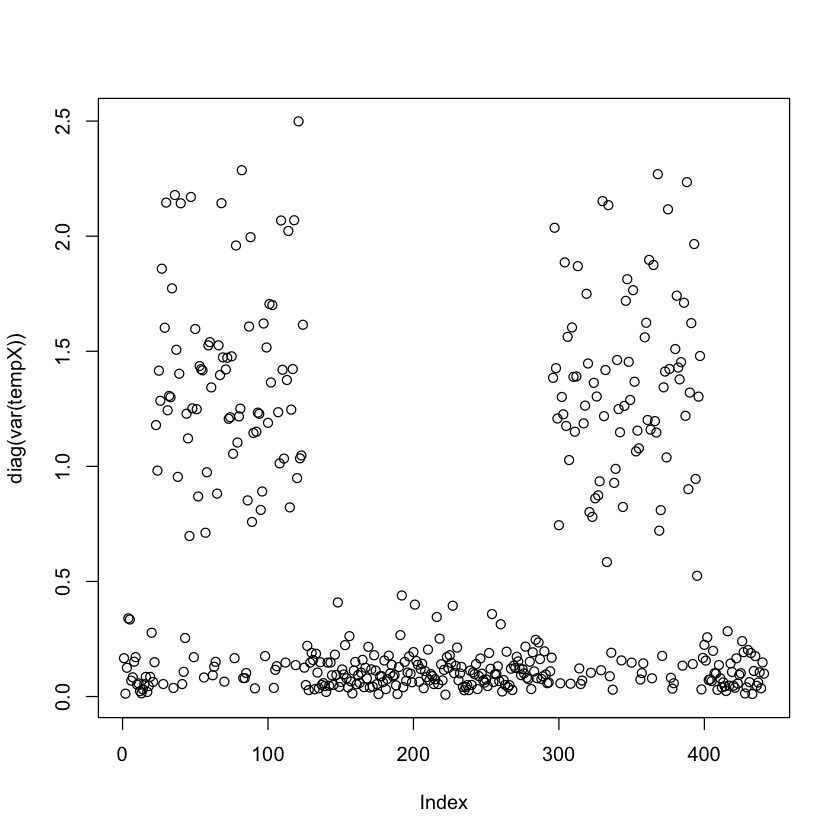

In [25]:
plot(diag(var(tempX)))

In [26]:
X <- scale(tempX)

# Question 2: Data analysis, results visualization, & performance metrics


## 1 Retriving SM and TC for RR

In [27]:
D = TC

In [28]:
A_LSR <- solve(t(D)%*%D)%*%t(D)%*%X
D_LSR <- X%*%t(A_LSR)

In [29]:
pdf(file = "./images/retrieved_SM_TC_subplots.pdf", width = 8, height = 5)
par(mar=c(2,1,1,4.5))
par(mfrow = c(3, 4))
for (i in 1:nsrcs) {
    plot(matrix(A_LSR[i, ], nrow = 21, ncol = 21), main=paste("Retrieved SM", i),  xlab="", ylab="", col = heat.colors(8))
    plot(D_LSR[,i], type="S", main=paste("Retrieved TC", i), xlab="", ylab="")
}
dev.off()

pdf 
  2

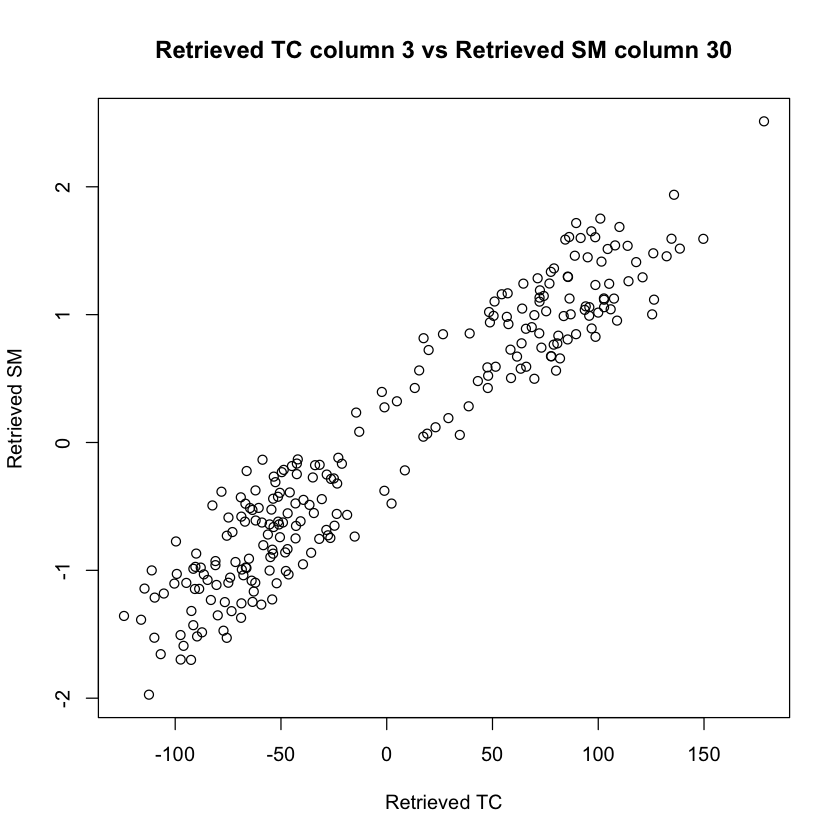

In [30]:
plot(x=D_LSR[,3], y=X[,30], main = "Retrieved TC column 3 vs Retrieved SM column 30", xlab = "Retrieved TC", ylab="Retrieved SM")

## 2 Estimate PR parameters

In [31]:
generate_A_RR <- function(lambda) {
    return(solve(t(D)%*%D+lambda*V*diag(6))%*%t(D)%*%X)
}

In [32]:
cor_RR <- function(lambda) {
    D_RR <- X%*%t(generate_A_RR(lambda))
    return(sum(calc.maxcor(TC, D_RR)))
}

In [33]:
optimize(cor_RR, interval=c(0, 1))

$minimum
[1] 0.9999339

$objective
[1] 5.414481

In [34]:
# Pick lambda=1

In [35]:
(c_TLSR <- sum(calc.maxcor(TC, D_LSR)))

[1] 5.25104

In [36]:
(c_TRR.1 <- cor_RR(1))

[1] 5.414479

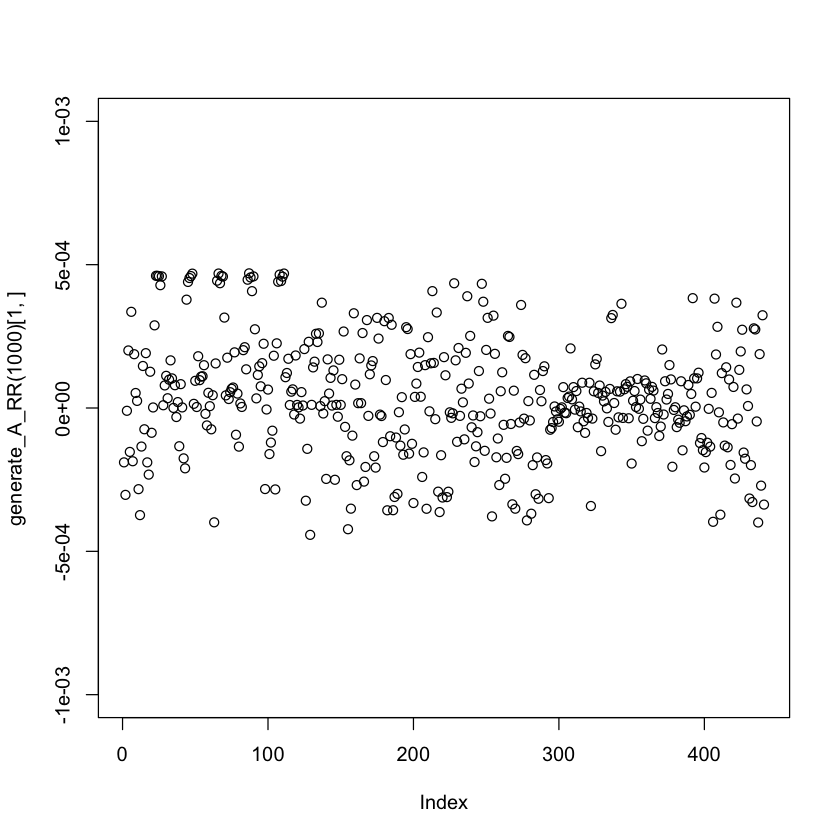

In [37]:
plot(generate_A_RR(1000)[1, ], ylim=c(-1e-3, 1e-3))

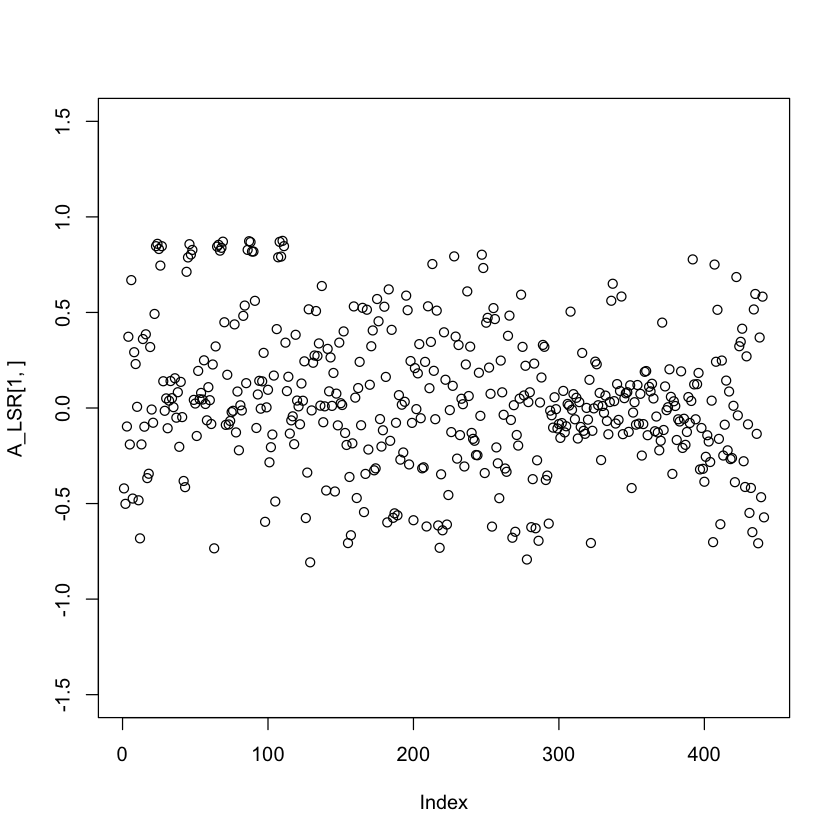

In [38]:
plot(A_LSR[1,], ylim=c(-1.5, 1.5))

## 3 Retriving SM and TC for LR

In [39]:
rhos <- seq(0, 1, 0.05)

In [40]:
generate_A_LR <- function(X, TC, rho) {
    step <- 1/(norm(TC%*%t(TC)) * 1.1)
    thr <- rho*N*step
    Ao <- matrix(0, nsrcs, 1)
    A <- matrix(0, nsrcs, 1)
    A_LR <- matrix(0, nsrcs, x1*x2)

    for (k in 1:(x1*x2)) {
        A <- Ao+step*(t(TC) %*% (X[,k]-(TC%*%Ao)))
        A <- (1/(1+thr)) * (sign(A)*pmax(replicate(nsrcs, 0), abs(A)-thr))

        for (i in 1:10) {
            Ao <- A
            A <- Ao+step * (t(TC)%*%(X[,k]-(TC%*%Ao)))
            A <- (1/(1+thr)) * (sign(A)*pmax(replicate(nsrcs, 0), abs(A)-thr))
        }
        A_LR[,k] <- A
    }
    return(A_LR)
}

In [41]:
generate_X <- function() {
    gamma_t <- matrix(rnorm(N*nsrcs, mean = 0, sd = sqrt(t_var)), nrow = N, ncol = nsrcs)
    gamma_s <- matrix(rnorm(nsrcs*V, mean = 0, sd = sqrt(s_var)), nrow = nsrcs, ncol = V)
    return(scale((TC+gamma_t)%*%(SM+gamma_s)))
}

In [42]:
MSEs <- matrix(0, length(rhos), 1)
for (i in 1:length(rhos)) {
    MSE = matrix(0, 10, 1)
    for (j in 1:10) {
        newX <- generate_X()
        tempA_LR = generate_A_LR(newX, TC, rhos[i])
        tempD_LR = newX%*%t(tempA_LR)
        temp = newX - tempD_LR%*%tempA_LR 
        MSE[j] <- sum(temp^2) / (N*V)
    }
    MSEs[i] <- mean(MSE)
}

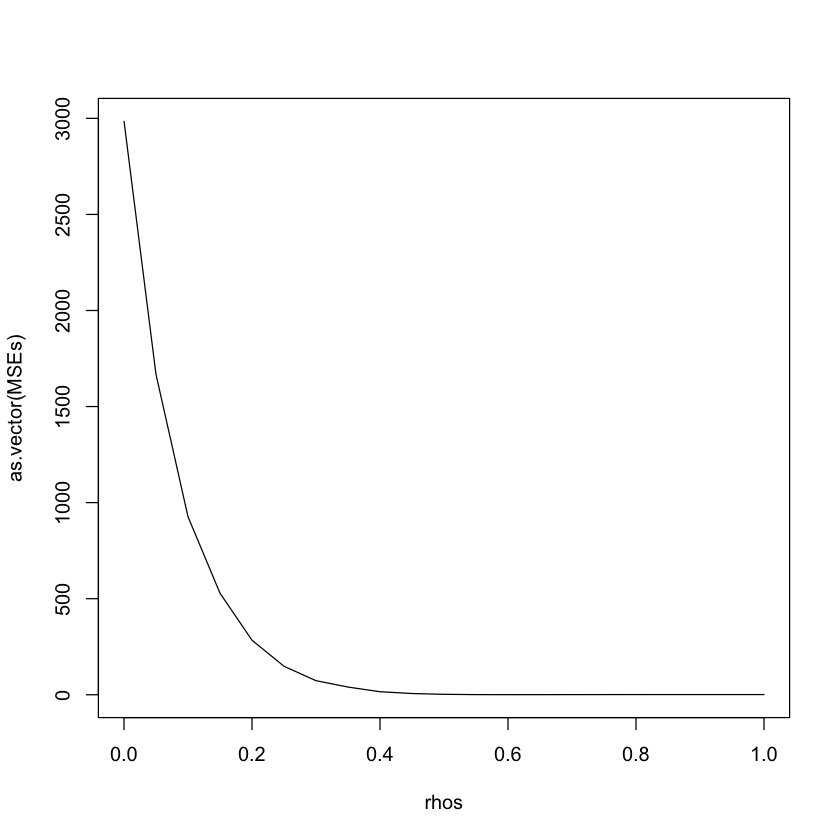

In [43]:
plot(x =rhos ,y=as.vector(MSEs), type="l")

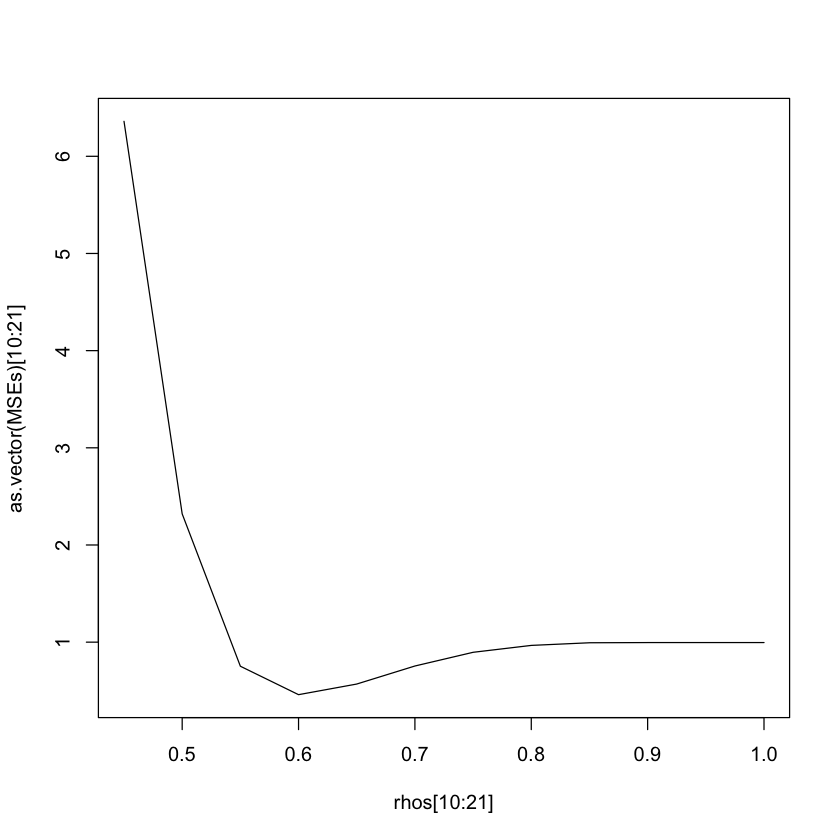

In [44]:
plot(x =rhos[10:21] ,y=as.vector(MSEs)[10:21], type="l")

## 4 Estimate LR parameters

In [45]:
rho = 0.6
lambda = 1

In [46]:
A_RR <- generate_A_RR(lambda)
D_RR <- X%*%t(A_RR)
A_LR <- generate_A_LR(X, TC, rho)
D_LR <- X%*%t(A_LR)

In [47]:
# TC and D_RR
(c_TRR <- sum(calc.maxcor(TC, D_RR)))

[1] 5.414479

In [48]:
# SM and A_RR
(c_SRR <- sum(calc.maxcor(SM, A_RR)))

[1] 352.0149

In [49]:
# TC and  D_LR
(c_TLR <- sum(calc.maxcor(TC, D_LR)))

[1] 5.439354

In [50]:
# SM and A_LR
(c_SLR <- sum(calc.maxcor(SM, A_LR)))

[1] 362.7012

In [51]:
pdf(file = "./images/SM_TC_RR_LR_subplots.pdf", width = 8, height = 10)
par(mar=c(2,1,1,4.5))
par(mfrow = c(6, 4))
for (i in 1:nsrcs) {
    plot(matrix(A_RR[i, ], nrow = 21, ncol = 21), main=paste("Retrieved SM RR", i),  xlab="", ylab="", col = heat.colors(8))
    plot(D_RR[,i], type="S", main=paste("Retrieved TC RR", i), xlab="", ylab="")
    plot(matrix(A_LR[i, ], nrow = 21, ncol = 21), main=paste("Retrieved SM LR", i),  xlab="", ylab="", col = heat.colors(8))
    plot(D_LR[,i], type="S", main=paste("Retrieved TC LR", i), xlab="", ylab="")
}
dev.off()

pdf 
  2

## 5 Estimate PCs of TCs

In [52]:
TC_SVD <- svd(TC)

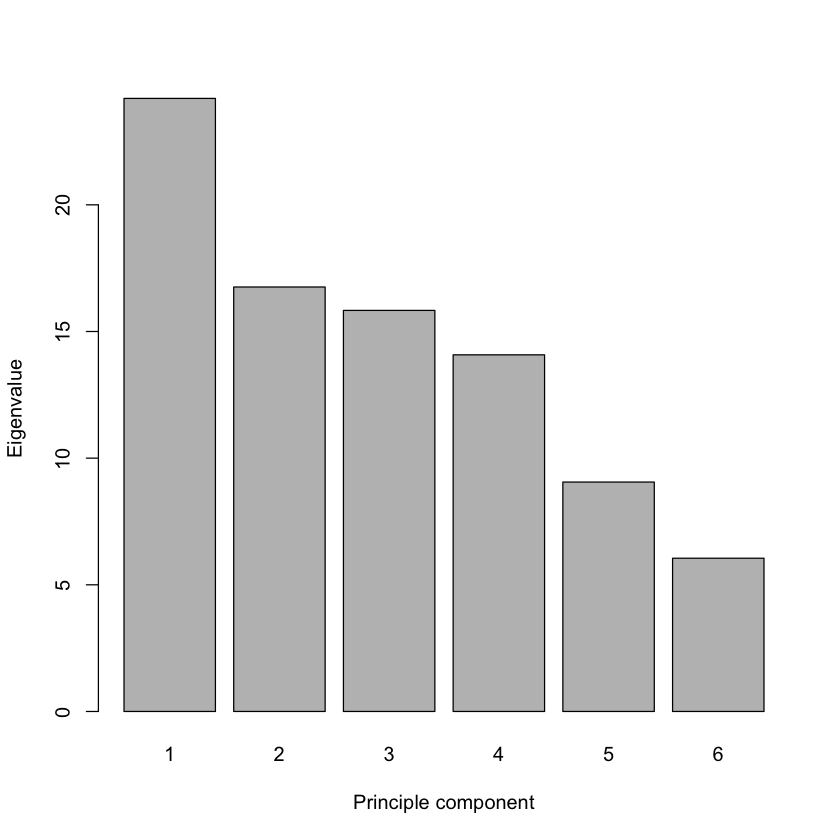

In [53]:
barplot(TC_SVD$d, xlab="Principle component", ylab="Eigenvalue", names=1:6)

In [54]:
Z <- TC_SVD$u

In [55]:
pdf(file = "./images/PCA_TC_subplots.pdf", width = 8, height = 5)
par(mfrow = c(3, 4))
par(mar=c(2, 2, 2, 2))
for (i in rep(1:nsrcs)) {
    plot(Z[,i], type="S", main=paste("Z variable", i), xlab="", ylab="")    
    plot(TC[,i], type="S", main=paste("TC variable", i), xlab="", ylab="")
}
dev.off()

pdf 
  2

In [56]:
A_PCR <- generate_A_LR(X, Z, 0.001)
D_PCR <- X%*%t(A_PCR)

In [57]:
pdf(file = "./images/D_PCR_A_PCR_subplots.pdf", width = 8, height = 5)
par(mar=c(2,1,1,4.5))
par(mfrow = c(3, 4))
for (i in 1:nsrcs) {
    plot(matrix(A_PCR[i, ], nrow = 21, ncol = 21), main=paste("Retrieved SM PCR", i),  xlab="", ylab="", col = heat.colors(8))
    plot(D_PCR[,i], type="S", main=paste("Retrieved TC PCR", i), xlab="", ylab="")
}
dev.off()

pdf 
  2